In [43]:
import numpy as np
import torch
import torch.nn as nn
import torchvision

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
import torchvision.transforms as tt

import matplotlib.pyplot as plt

In [2]:
CATEGORIES = ["01_palm", '02_l','03_fist','04_fist_moved','05_thumb','06_index','07_ok','08_palm_moved','09_c','10_down']
data_folder = './Data/leapGestRecog'

In [3]:
import os

In [47]:
IMG_CROP = 240
IMG_SIZE = 64
BATCH_SIZE=64

In [54]:
transforms = tt.Compose([tt.Grayscale(num_output_channels=1), tt.CenterCrop(IMG_CROP), tt.Resize(IMG_SIZE), tt.ToTensor()])

In [60]:
data = None
for folder in os.listdir(data_folder):
    images = ImageFolder(os.path.join(data_folder, folder), transforms)
    if data:
        data = data + images
    else:
        data = images

In [61]:
train, test = random_split(data, [15000, 5000])

In [62]:
train_data_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
test_data_loader = DataLoader(test, batch_size=BATCH_SIZE)

In [63]:
def showbatch(batch):
    for images, labels in batch:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

torch.Size([1, 64, 64])


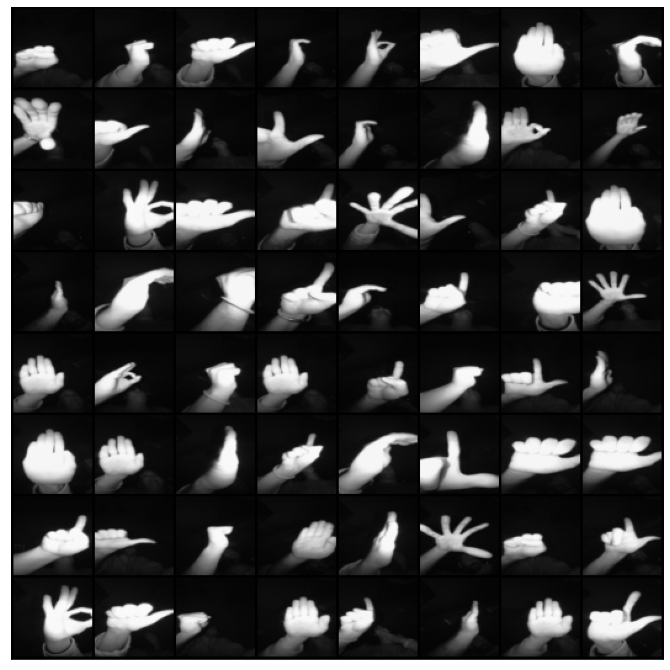

In [64]:
showbatch(train_data_loader)

In [95]:
class HGRecognition(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = self.conv_block(1, 32, pool=False)
        self.conv2 = self.conv_block(32, 32, pool=True)
        self.conv3 = self.conv_block(32, 64, pool=True)
        self.drop = nn.Dropout(0.3)
        self.dense = nn.Sequential(nn.Flatten(), nn.Linear(64*6*6, 256), nn.ReLU(inplace=True), 
                                  nn.Linear(256, 10), nn.Softmax(dim=1))
        
    @staticmethod
    def conv_block(in_feat, out_feat, pool=False):
        layers = [nn.Conv2d(in_feat, out_feat, kernel_size=3), nn.ReLU(inplace=True)]
        if pool:
            layers.append(nn.MaxPool2d(kernel_size=3))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.drop(out)
        out = self.conv3(out)
        out = self.drop(out)
        #print(out.size())
        out = self.dense(out)
        
        return out

In [133]:
def accuracy(pred, true):
    pred = np.argmax(pred.to('cpu').detach().numpy(), axis=1)
    true = true.to('cpu').detach().numpy()
    return len(np.where(pred==true)[0])/len(true)

In [134]:
hg = HGRecognition()

In [135]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(hg.parameters(), lr=0.001, weight_decay=1e-6)

In [136]:
EPOCHS=15

In [137]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [138]:
hg.to(device)

HGRecognition(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (drop): Dropout(p=0.3, inplace=False)
  (dense): Sequential(
    (0): Flatten()
    (1): Linear(in_features=2304, out_features=256, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=256, out_features=10, bias=True)
    (4): Softmax(dim=1)
  )
)

In [139]:
train_loss_history = []
accuracy_history = []

for epoch in range(EPOCHS):
    epoch_accuracy = []
    epoch_loss = []
    for images, labels in train_data_loader:
        
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        
        outputs = hg(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss.append(loss.item())
        epoch_accuracy.append(accuracy(outputs, labels))
    
    train_loss_history.append(np.mean(epoch_loss))
    accuracy_history.append(np.mean(epoch_accuracy))
    print(f'Epoch {epoch+1}, loss: {np.mean(epoch_loss)}, accuracy: {np.mean(epoch_accuracy)}')

Epoch 1, loss: 2.131653990136816, accuracy: 0.3103945035460993
Epoch 2, loss: 1.7493983750647686, accuracy: 0.713674645390071
Epoch 3, loss: 1.6527571546270492, accuracy: 0.808732269503546
Epoch 4, loss: 1.6080721378326417, accuracy: 0.8535904255319149
Epoch 5, loss: 1.5283063249385103, accuracy: 0.9341976950354609
Epoch 6, loss: 1.5130101802501272, accuracy: 0.9486258865248226
Epoch 7, loss: 1.4992708759104951, accuracy: 0.9626773049645391
Epoch 8, loss: 1.4841598160723422, accuracy: 0.9776595744680852
Epoch 9, loss: 1.4798175192893819, accuracy: 0.9816046099290779
Epoch 10, loss: 1.4790800292441186, accuracy: 0.9824689716312056
Epoch 11, loss: 1.475961544158611, accuracy: 0.9851063829787234
Epoch 12, loss: 1.4755659138902706, accuracy: 0.9855053191489361
Epoch 13, loss: 1.474685004924206, accuracy: 0.986857269503546
Epoch 14, loss: 1.4735997965995302, accuracy: 0.9875221631205673
Epoch 15, loss: 1.4744609295053686, accuracy: 0.9868351063829788


In [140]:
test_loss_history = []
test_accuracy = []
for data, labels in test_data_loader:
    data = data.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        out = hg(data)
        loss = criterion(out, labels)
        test_loss_history.append(loss.item())
        test_accuracy.append(accuracy(out, labels))
        
print(f'Test loss after {EPOCHS} epochs: {np.mean(test_loss_history)}. Accuracy: {np.mean(test_accuracy)}')

Test loss after 15 epochs: 1.4717554412310636. Accuracy: 0.9897151898734177


In [141]:
torch.save(hg.state_dict(), './Models/Hand_Gesture_Recognition.pth')